In [1]:
import cv2
import torch
import nltk
import numpy as np

from tqdm import tqdm
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from collections import Counter

In [2]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [3]:
def extract_frames(video_path, every_n_frames=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        if count % every_n_frames == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        count += 1

    cap.release()
    return frames

In [4]:
video_path = "/content/source_video.mp4"

In [5]:
frames = extract_frames(video_path, every_n_frames=5)

len(frames)

60

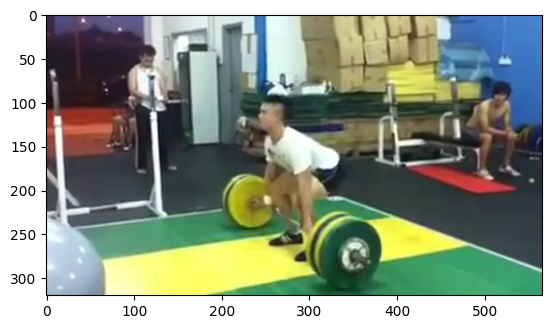

In [6]:
import matplotlib.pyplot as plt

plt.imshow(frames[0])
plt.show()

In [7]:
def extract_nouns_verbs(texts):
    nouns = []
    verbs = []

    for text in texts:
        tokens = nltk.word_tokenize(text)
        pos_tags = nltk.pos_tag(tokens)

        for word, tag in pos_tags:
            if tag.startswith('NN'):
                nouns.append(word.lower())
            elif tag.startswith('VB'):
                verbs.append(word.lower())

    return nouns, verbs

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

https://huggingface.co/nlpconnect/vit-gpt2-image-captioning

In [9]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)
processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [10]:
def caption_image(image):
    inputs = processor(images=image, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_length=16)
    caption = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return caption

In [11]:
captions = []

for frame in tqdm(frames):
    caption = caption_image(frame)
    captions.append(caption)

captions[:10]


  0%|          | 0/60 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.

100%|██████████| 60/60 [01:50<00:00,  1.84s/it]


['a woman is standing on a green and white tiled floor ',
 'a person is standing on a green and white tiled floor ',
 'a man is holding a toy in a park ',
 'a man in a yellow shirt is playing with a toy ',
 'a young man holding a yellow frisbee in a gym ',
 'a man in a yellow shirt is playing with a frisbee ',
 'a man in a yellow shirt is playing frisbee ',
 'a man in a yellow shirt is playing with a toy ',
 'a toy elephant is in a toy arena ',
 'a toy elephant is standing on a table ']

In [12]:
nouns, verbs = extract_nouns_verbs(captions)

noun_counts = Counter(nouns)
verb_counts = Counter(verbs)

top_nouns = noun_counts.most_common(10)
top_verbs = verb_counts.most_common(10)

top_nouns, top_verbs

([('man', 51),
  ('frisbee', 39),
  ('shirt', 22),
  ('gym', 12),
  ('game', 9),
  ('toy', 8),
  ('woman', 6),
  ('floor', 6),
  ('top', 5),
  ('room', 4)],
 [('is', 45), ('playing', 28), ('holding', 21), ('standing', 11)])

https://huggingface.co/Salesforce/blip-image-captioning-base

In [13]:
from transformers import BlipProcessor, BlipForConditionalGeneration

In [14]:
blit_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blit_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [15]:
def blit_caption_image(image):
    inputs = blit_processor(images=image, return_tensors="pt").to(device)
    outputs = blit_model.generate(**inputs, max_length=16)
    caption = blit_processor.decode(outputs[0], skip_special_tokens=True)

    return caption

In [16]:
blit_captions = []

for frame in tqdm(frames):
    caption = blit_caption_image(frame)
    blit_captions.append(caption)

blit_captions[:10]


100%|██████████| 60/60 [03:21<00:00,  3.36s/it]


['a man is doing a squat exercise in a gym',
 'a man squats on a barbell in a gym',
 'a man squats on a barbell in a gym',
 'a man is doing a squat exercise in a gym',
 'a man is doing a squat exercise in a gym',
 'a man is doing a squat exercise in a gym',
 'a man is doing a squat exercise in a gym',
 'a man is doing a squat exercise in a gym',
 'a man is doing a squat exercise in a gym',
 'a man squats on a barbell in a gym']

In [17]:
nouns, verbs = extract_nouns_verbs(blit_captions)

noun_counts = Counter(nouns)
verb_counts = Counter(verbs)

top_nouns = noun_counts.most_common(10)
top_verbs = verb_counts.most_common(10)

top_nouns, top_verbs

([('man', 59),
  ('exercise', 51),
  ('gym', 29),
  ('weightlifting', 26),
  ('squat', 25),
  ('barbell', 4),
  ('weight', 1),
  ('woman', 1)],
 [('is', 57), ('doing', 56), ('squats', 3), ('lifting', 1)])